# Homework 7

Understanding the difference between Adagrad, RMSprop, and Adadelta. The purpose of these three methods is to minimize the influence of the learning rate, as it determines how quickly a model adapts to a given problem. Larger learning rates cause rapid convergence and require fewer iterations. However, the larger learning rates will likely fail to converging to the true minima. On the other hand, smaller learning rates require more iterations with the exchange of better convergence to the true minima. Nevertheless, optimizing a huge parameter space can render to be troublesome, as the convergence is too slow.

Here we will still use Rosenbrock function with b=100 identical to Homework 6.

Lastly, we will also explore ADAM.

In [1]:
using Plots
using LinearAlgebra
plotly()
gr()

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /Users/yanxon/.julia/packages/Plots/Xnzc7/src/backends.jl:375


Plots.GRBackend()

In [2]:
# Rosenbrock function

f_r(x) = (1-x[1])^2 + 100*(4x[2] - x[1]^2)^2
∇f_r(x) = [2*(200x[1]^3 - 800x[1]*x[2] + x[1] - 1), -800*(x[1]^2 - 4x[2])]

function rosenplot()
    _f(x, y) = (1-x)^2 + 100*(4y - x^2)^2
    xmin, xmax, ymin, ymax = -3, 2, -0.5, 2
    x, y = xmin:0.01:xmax, ymin:0.01:ymax
    contour(x, y, _f,
            size=(500, 250),
            levels=[2,10,50,200,500],
            framestyle=:box,
            xlims=(xmin, xmax),
            ylims=(ymin, ymax),
            )
end

rosenplot (generic function with 1 method)

In [45]:
abstract type DescentMethod end

mutable struct Adagrad <: DescentMethod
    x
    α
    ϵ
    s
end

function step!(M::Adagrad, f, ∇f)
    α, ϵ, s, g = M.α, M.ϵ, M.s, ∇f(M.x)
    s[:] += g.*g # Here s will point to M.s
    M.x -= α*g ./ (sqrt.(s) .+ ϵ)
end

mutable struct RMSProp <: DescentMethod    
    x
    α
    γ
    ϵ
    s
end

function step!(M::RMSProp, f, ∇f)
    α, γ, ϵ, s, g = M.α, M.γ, M.ϵ, M.s, ∇f(M.x)
    s[:] = γ*s + (1-γ)*(g.*g)
    M.x -= α*g ./ (sqrt.(s) .+ ϵ)
end

mutable struct Adadelta <: DescentMethod
    x
    γs # gradient decay
    γx # update decay
    ϵ # small value
    s # sum of squared gradients
    u # sum of squared updates
end

function step!(M::Adadelta, f, ∇f)
    γs, γx, ϵ, s, u, g = M.γs, M.γx, M.ϵ, M.s, M.u, ∇f(M.x)
    s[:] = γs*s + (1-γs)*g.*g
    Δx = - (sqrt.(u) .+ ϵ) ./ (sqrt.(s) .+ ϵ) .* g
    M.x += Δx
    u[:] = γx*u + (1-γx)*Δx.*Δx # update u for the (k+1)-th
end

step! (generic function with 3 methods)

In [46]:
function optimize(M, f, ∇f; max_iter=40, model="Adagrad")
    x = rand(1, length(M.x))
    for (i, m) in enumerate(M.x)
        x[i] = m
    end
    
    for i in 1:max_iter
        x_prev = M.x
        if model == "Adagrad"
            step!(M::Adagrad, f, ∇f)
        elseif model == "RMSprop"
            step!(M::RMSProp, f, ∇f)
        elseif model == "Adadelta"
            step!(M::Adadelta, f, ∇f)
        end
        x = [x; (M.x)']
    end
    return x
end

optimize (generic function with 1 method)

In [62]:
x0 = [0, 1.5]
α, ϵ, s = 0.003, 1e-08, zeros(length(x0))
γ = 0.9
γs, γx, u = 0.99, 1, zeros(length(x0))
# The original paper use γx = 1

N = 400
M_adagrad = Adagrad(x0, α, ϵ, s)
xs_adagrad = optimize(M_adagrad, f_r, ∇f_r, max_iter=N, model="Adagrad")

M_rmsprop = RMSProp(x0, α, γ, ϵ, s)
xs_rmsprop = optimize(M_rmsprop, f_r, ∇f_r, max_iter=N, model="RMSProp")

M_adadelta = Adadelta(x0, γs, γx, ϵ, s, u)
xs_adadelta = optimize(M_adadelta, f_r, ∇f_r, max_iter=N, model="Adadelta");

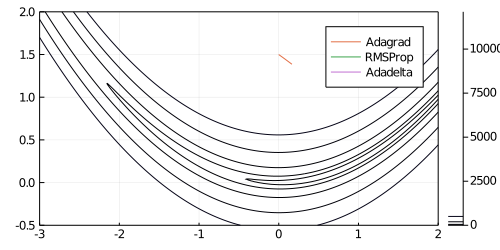

In [63]:
rosenplot()
plot!(xs_adagrad[:,1], xs_adagrad[:,2], label="Adagrad")
plot!(xs_rmsprop[:,1], xs_rmsprop[:,2], label="RMSProp")
plot!(xs_adadelta[:,1], xs_adadelta[:,2], label="Adadelta")

**Conclusion**: Perhaps, these three optimizers are not appropriate for Rosenbrock banana function.

## Adam

In [49]:
mutable struct Adam <: DescentMethod
    x # positions
    α # learning rate
    γv # decay
    γs # decay
    ϵ # small value
    k # step counter
    v # 1st moment estimate
    s # 2nd moment estimate
end

function step!(M::Adam, f, ∇f)
    α, γv, γs, ϵ, k = M.α, M.γv, M.γs, M.ϵ, M.k
    s, v, g = M.s, M.v, ∇f(M.x)
    M.v = γv*v + (1-γv)*g
    M.s = γs*s + (1-γs)*g.*g
    M.k += 1
    v_hat = M.v ./ (1 - γv^k)
    s_hat = M.s ./ (1 - γs^k)
    M.x -= α*v_hat ./ (sqrt.(s_hat) .+ ϵ)    
end

function optimize(M::Adam, f, ∇f; f_tol=1e-10, g_tol=1e-4, max_iter=1000)
    xs = copy(M.x)'
    for i in 1:max_iter
        x_prev = M.x
        step!(M::Adam, f, ∇f)
        xs = [xs; (M.x)']
        
        if abs(f(M.x)[1]-f(x_prev)[1]) < f_tol
            println("Terminate due to function value tolerance")
            break
        elseif norm(∇f(M.x)) < g_tol
            println("Terminate due to gradient tolerance")
            break
        end
    end
    return xs
end

optimize (generic function with 2 methods)

In [53]:
# Rosenbrock function
f_rb_quad(x, y) = (1-x)^2 + 100*(4y - x^2)^2 #quadratic form
f_rb(x) = (1-x[1])^2 + 100*(4x[2] - x[1]^2)^2 # vector form
∇f_rb(x) = [2*(200x[1]^3 - 800x[1]*x[2] + x[1] - 1), -800*(x[1]^2 - 4x[2])]

function rosenplot(f; xlims=(-3,2), ylims=(-0.5,2))
    x = xlims[1]:0.01:xlims[2]
    y = ylims[1]:0.01:ylims[2]
    contour(x, y, f,
        size=(800, 250),
        framestyle=:box,
        color = cgrad(:viridis),
        levels=[2,10,50,200,500],
        clims=(0, 601),
        legend=(loc=:outertopright),
        xlims=xlims,
        ylims=ylims,
    )
end

rosenplot (generic function with 2 methods)

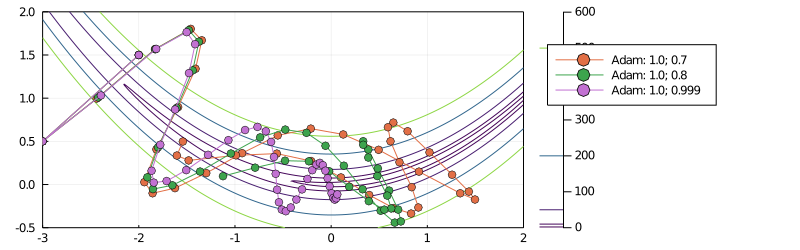

In [61]:
x0 = [-2, 1.5]
N_iter = 40
base = rosenplot(f_rb_quad, xlims=(-3, 2), ylims=(-0.5, 2))

for r in [0.7, 0.8, 0.999]
    M = Adam(x0, 1e-0, 0.9, r, 1e-8, 1, zeros(length(x0)), zeros(length(x0)))
    xs = optimize(M, f_rb, ∇f_rb, max_iter=N_iter)
    plot!(base, [xs[:,1]], [xs[:,2]], m=:o, label=string("Adam: ", M.α, "; ", M.γs) )
end
base